In [1]:
%%capture --no-stderr
%load_ext autoreload
%autoreload 2

In [2]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

In [3]:
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool
from typing import Annotated, Literal

In [4]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0
)

We're going to create agents that will be able to search the internet and write and execute code for us!

In [5]:
tavily_tool = TavilySearchResults(max_results=5)
python_repl_tool = PythonREPLTool()

Creating an agent `node`. This node will be used to represent agents in the graph state

In [6]:
from langchain_core.messages import HumanMessage

def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)]
    }

## Create agent supervisor
This agent uses function calling to choose the next worker node or finish processing.

In [7]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from pydantic import BaseModel

members = ["Researcher", "Coder"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)
options = ["FINISH"] + members


class routeResponse(BaseModel):
    next: Literal[*options]

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

Using `.partial` creates a new ChatPromptTemplate with some input variables already filled in. This is a LangChain specific implementation of the `.partial` method of the `functools` library.

In [8]:
def supervisor_agent(state):
    """This is the supervisor node
    
    It just picks the next agent to process and decides when the work is completed"""
    supervisor_chain = prompt | llm.with_structured_output(routeResponse)
    return supervisor_chain.invoke(state)

## Construct graph

In [9]:
import functools
import operator
from typing import Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver

This will be the `state` input to each node in the graph. The annotation tells the graph that new messages will always be added to the current states. The `next` field indicates where to route to next

In [10]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    next: str

Create research agent and the research agent node
> Note the use of `partial` to fill in the arguments of the function of interest.

In [11]:
research_agent = create_react_agent(llm, tools=[tavily_tool])
research_node = functools.partial(
    agent_node,
    agent=research_agent,
    name="Researcher" #must match the name in the 'members' list above
)

Create code execution agent
> Note that this performs code execution on your computer! In production you'll need to create a sandboxed environment for this

In [12]:
code_agent = create_react_agent(llm, tools=[multiply])
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

A StateGraph is a graph whose nodes communicate by reading and writing to a shared state. It's the overarching graph class of the Langgraph library.

In [13]:
workflow = StateGraph(AgentState)

## Add nodes
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", code_node)
workflow.add_node("supervisor", supervisor_agent)

## Add edges
### We want our workers to always report back to our supervisor when done
for member in members:
    workflow.add_edge(member, "supervisor")

### The supervisor then fills in the 'next' field in the graph state for routing
conditional_map = {k:k for k in members}
conditional_map['FINISH'] = END
workflow.add_conditional_edges(
    "supervisor", lambda x: x['next'],
    conditional_map
)

### Connect entrypoint to supervisor
workflow.add_edge(START, "supervisor")

## Add memory - this creates chat history of the graph in an in-memory SQLite database
memory = MemorySaver()

## Compile
### We interrupt before the code execution just to ensure that we're not doing anything cray
graph = workflow.compile(
    interrupt_before=["Coder"], 
    checkpointer=memory
)

Here's what our graph looks like!

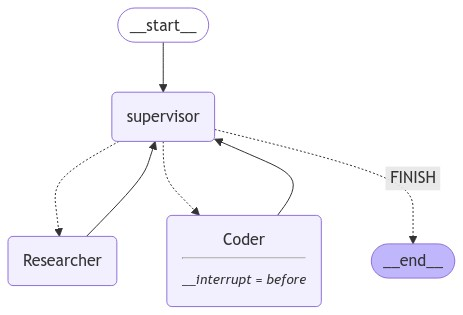

In [14]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

## Let's do some research into the future of generative AI!

In [15]:
thread = {"configurable": {"thread_id": "88"}} #for memory

You'll notice that there appears to be a duplication - this is just because the supervisor first invokes the state, passes it to another agent that invokes the state again. Once this agent is done the supervisor invokes the state yet again to determine if more routing is needed or we can just end.

In [16]:
for event in graph.stream(
    {
        "messages": [
            HumanMessage(content="Is generative AI just a gimmick? Does it have any quantifiable business value?")
        ]
    },
    thread,
    stream_mode = "values"
):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Is generative AI just a gimmick? Does it have any quantifiable business value?
================================ Human Message =================================

Is generative AI just a gimmick? Does it have any quantifiable business value?
================================ Human Message =================================
Name: Researcher

Generative AI is increasingly recognized for its tangible business value rather than being merely a gimmick. Here are some key insights regarding its quantifiable benefits:

1. **Performance Improvement**: According to IBM Consulting, generative AI can augment existing enterprise AI deployments, leading to improved performance and accelerated time to value. Businesses that carefully develop generative AI solutions can see significant enhancements in their operations.

2. **Maximizing ROI**: Deloitte emphasizes the importance of understanding how to assess the value of gene

In [17]:
graph_state = graph.get_state(thread)

In [18]:
graph_state.values['messages']

[HumanMessage(content='Is generative AI just a gimmick? Does it have any quantifiable business value?', additional_kwargs={}, response_metadata={}, id='3e9fdc81-ac87-4671-8473-4bd6667dc175'),
 HumanMessage(content="Generative AI is increasingly recognized for its tangible business value rather than being merely a gimmick. Here are some key insights regarding its quantifiable benefits:\n\n1. **Performance Improvement**: According to IBM Consulting, generative AI can augment existing enterprise AI deployments, leading to improved performance and accelerated time to value. Businesses that carefully develop generative AI solutions can see significant enhancements in their operations.\n\n2. **Maximizing ROI**: Deloitte emphasizes the importance of understanding how to assess the value of generative AI investments. Organizations can compare different opportunities and prioritize use cases that align with broader business goals, thereby maximizing return on investment.\n\n3. **Decision Framew

And we have chat history!

In [19]:
from IPython.display import display, Markdown

display(Markdown(graph_state.values['messages'][-1].content))

Generative AI is increasingly recognized for its tangible business value rather than being merely a gimmick. Here are some key insights regarding its quantifiable benefits:

1. **Performance Improvement**: According to IBM Consulting, generative AI can augment existing enterprise AI deployments, leading to improved performance and accelerated time to value. Businesses that carefully develop generative AI solutions can see significant enhancements in their operations.

2. **Maximizing ROI**: Deloitte emphasizes the importance of understanding how to assess the value of generative AI investments. Organizations can compare different opportunities and prioritize use cases that align with broader business goals, thereby maximizing return on investment.

3. **Decision Framework**: Gartner suggests that businesses should assess the potential benefits and costs of generative AI investments. They provide a decision framework to help organizations evaluate the cost and realize value from their generative AI initiatives.

4. **Widespread Adoption**: A McKinsey survey indicates that 65% of organizations are regularly using generative AI, nearly double the percentage from the previous year. This growing adoption reflects a recognition of the technology's value in various business contexts.

5. **Versatile Applications**: Forbes highlights that large language models (LLMs), a form of generative AI, are versatile tools capable of performing a wide range of tasks. This versatility can enhance product development, customer experiences, and more, although concerns about privacy and data use remain prevalent among employees and business owners.

In summary, generative AI is proving to have quantifiable business value through improved performance, ROI maximization, and widespread adoption across industries. However, businesses must also navigate the associated risks and ethical considerations.

## Write code to do stuff!

In [27]:
for event in graph.stream(
    {
        "messages": [
            HumanMessage(
                content= "Write python code to calculate the remainder of 15/2"
            )
        ]
    },
    thread, 
    stream_mode='values'
):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Write python code to calculate the remainder of 15/2
================================ Human Message =================================

Write python code to calculate the remainder of 15/2


Tada it has stopped! Let's apply a state update

In [28]:
state = graph.get_state(thread)

In [29]:
state.values['messages'][-1]

HumanMessage(content='Write python code to calculate the remainder of 15/2', additional_kwargs={}, response_metadata={})

This is indeed our message. Let's update the state!

In [30]:
graph.update_state(
    thread,
    {
        "messages": [HumanMessage(
            content="No, actually write python code to calculate the remainder of 13 and 3!"
        )]
    }
)

{'configurable': {'thread_id': '88',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef97766-9808-600a-800d-63c5932c956d'}}

### Check if state has been updated!

In [31]:
new_state = graph.get_state(thread).values

In [32]:
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

Is generative AI just a gimmick? Does it have any quantifiable business value?
================================ Human Message =================================
Name: Researcher

Generative AI is increasingly recognized for its tangible business value rather than being merely a gimmick. Here are some key insights regarding its quantifiable benefits:

1. **Performance Improvement**: According to IBM Consulting, generative AI can augment existing enterprise AI deployments, leading to improved performance and accelerated time to value. Businesses that carefully develop generative AI solutions can see significant enhancements in their operations.

2. **Maximizing ROI**: Deloitte emphasizes the importance of understanding how to assess the value of generative AI investments. Organizations can compare different opportunities and prioritize use cases that align with broader business goals, thereby maximizing retu

### Invoke graph on revised question
We use the trick of passing `None` to proceed!

In [33]:
for s in graph.stream(None, thread, stream_mode="values"):
    if "__end__" not in s:
        print(s)
        print("----")

{'messages': [HumanMessage(content='Is generative AI just a gimmick? Does it have any quantifiable business value?', additional_kwargs={}, response_metadata={}, id='3e9fdc81-ac87-4671-8473-4bd6667dc175'), HumanMessage(content="Generative AI is increasingly recognized for its tangible business value rather than being merely a gimmick. Here are some key insights regarding its quantifiable benefits:\n\n1. **Performance Improvement**: According to IBM Consulting, generative AI can augment existing enterprise AI deployments, leading to improved performance and accelerated time to value. Businesses that carefully develop generative AI solutions can see significant enhancements in their operations.\n\n2. **Maximizing ROI**: Deloitte emphasizes the importance of understanding how to assess the value of generative AI investments. Organizations can compare different opportunities and prioritize use cases that align with broader business goals, thereby maximizing return on investment.\n\n3. **Dec

In [35]:
state = graph.get_state(thread)
display(Markdown(state.values['messages'][-1].content))

Here is the Python code to calculate the remainder of 13 divided by 3:

```python
remainder = 13 % 3
print(remainder)
```

When you run this code, it will output the remainder of 13 divided by 3.